In [55]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LayerNormalization, Dense, Dropout, MultiHeadAttention, Layer,GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

In [56]:
final_df = pd.read_csv("../data/final_features_with_targets.csv", parse_dates=['Date'], index_col='Date')

final_df = final_df.dropna().copy()

assets = ['EEM', 'Gold', 'FTSE100', 'S&P500', 'Nikkei225', 'UST10Y']

#For each asset to pick pick all columns
feature_suffixes = ['log_ret', 'vol_30d', 'zscore', 'sma5', 'macd', 'vol_spike']
global_features = ['covid_flag']
lookback = 20

In [58]:
#Classification targets
for asset in assets:
    target_col = f"{asset}_target_5d"
    class_col = f"{asset}_target_class"
    final_df[class_col] = (final_df[target_col] > 0).astype(int)


lookback = 20
X_seq_dict = {}
y_seq_dict = {}

for asset in assets:
    print(f"Processing {asset}...")
    
    #All Columns + Covid Flag
    feature_cols = [f"{asset}_{f}" for f in feature_suffixes] + global_features
    target_class_col = f"{asset}_target_class"

    # Features and target  extraction 
    data = final_df[feature_cols + [target_class_col]].copy()

    # Chronological split
    split_idx = int(0.8 * len(data))
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]

    # Fit scaler on training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_data[feature_cols].values)
    X_test_scaled = scaler.transform(test_data[feature_cols].values)

    y_train = train_data[target_class_col].values
    y_test = test_data[target_class_col].values

    # Function to create sequences
    def create_sequences(X, y, lookback):
        Xs, ys = [], []
        for i in range(lookback, len(X)):
            Xs.append(X[i - lookback:i])
            ys.append(y[i])
        return np.array(Xs), np.array(ys)

    # Create sequences for both train and test
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, lookback)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, lookback)

    # Save to dictionary
    X_seq_dict[asset] = (X_train_seq, X_test_seq)
    y_seq_dict[asset] = (y_train_seq, y_test_seq)
    


Processing EEM...
Processing Gold...
Processing FTSE100...
Processing S&P500...
Processing Nikkei225...
Processing UST10Y...


In [59]:
#Testing the EEM data as a sample
asset_to_check = 'Gold'

X_train_seq, X_test_seq = X_seq_dict[asset_to_check]
y_train_seq, y_test_seq = y_seq_dict[asset_to_check]

print(f"{asset_to_check} →")
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_test_seq shape:  {X_test_seq.shape}")
print(f"y_test_seq shape:  {y_test_seq.shape}")


Gold →
X_train_seq shape: (2739, 20, 7)
y_train_seq shape: (2739,)
X_test_seq shape:  (670, 20, 7)
y_test_seq shape:  (670,)


In [60]:
#HyperParameters
seq_len = 20           # lookback already defined but name change for easier understanding
n_features = 7         # All the features we have creared initially 
embed_dim = 64          # Dimention embedding for each step 
num_heads = 4          # Multi head attention, can change this based on results 
ff_dim = 128           # Feedforward layer size inside Transformer block
dropout_rate = 0.1     # Regularization


In [61]:
#(Input: batch_size, seq_len, n_features)
input_layer = Input(shape=(seq_len, n_features))

In [62]:
#Tranformer Modeling

class TransformerEncoderBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [63]:


def transformer_classifier(seq_len, n_features, embed_dim=64, ff_dim=128, num_heads=4):
    inputs = Input(shape=(seq_len, n_features))

    #Inputs are expanded or projected to 64 dimensions 
    x = Dense(embed_dim)(inputs)

    # Encoder block
    num_encoder_blocks = 5 
    for _ in range(num_encoder_blocks):
        encoder_block = TransformerEncoderBlock(embed_dim=embed_dim, ff_dim=ff_dim, num_heads=num_heads)
        x = encoder_block(x)

    # Global pooling to flatten
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


transformer_model = transformer_classifier(
    seq_len=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2]
)

transformer_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

transformer_model.summary()



Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 20, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 20, 64)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block_5     │ (None, 20, 64)         │        83,200 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block_6     │ (None, 20, 64)         │        83,200 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block_7     │ (None, 20, 64)         │        83,200 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block_8     │ (None, 20, 64)         │        83,200 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block_9     │ (None, 20, 64)         │        83,200 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,737 (1.60 MB)

 Trainable params: 420,737 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
from tensorflow.keras.callbacks import EarlyStopping

# initiating dicts to store trained models and the history 
trained_models = {}
history_dict = {}


for asset in assets:
    print(f"--- Training model for {asset} ---")

 
    X_train_seq, X_test_seq = X_seq_dict[asset]
    y_train_seq, y_test_seq = y_seq_dict[asset]

    
    tf.keras.backend.clear_session()
    model = transformer_classifier(
        seq_len=seq_len,
        n_features=n_features,
        embed_dim=embed_dim,
        ff_dim=ff_dim,
        num_heads=num_heads
    )
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Earlystopping for preventing overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Training
    history = model.fit(
        X_train_seq,
        y_train_seq,
        epochs=100,  # started with 50 but increased for slightly better results
        batch_size=32,
        validation_split=0.2, 
        callbacks=[early_stopping],
        verbose=1
    )

  
    trained_models[asset] = model
    history_dict[asset] = history


    print(f"\n--- Evaluating {asset} on Test Data ---")
    test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_seq)
    print(f"Test Accuracy for {asset}: {test_accuracy:.4f}")
    print("-" * 40)



--- Training model for EEM ---
Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 252ms/step - accuracy: 0.4974 - loss: 0.8111 - val_accuracy: 0.4635 - val_loss: 0.7050
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.5107 - loss: 0.7544 - val_accuracy: 0.4708 - val_loss: 0.7120
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.4809 - loss: 0.7462 - val_accuracy: 0.4799 - val_loss: 0.7030
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.4838 - loss: 0.7392 - val_accuracy: 0.5237 - val_loss: 0.6961
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.4958 - loss: 0.7187 - val_accuracy: 0.5493 - val_loss: 0.6921
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.5015 - loss: 0.7078 - val_accuracy: 0.4690 - val_loss: 0.6957
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.5086 - loss: 0.7130 - val_accuracy: 0.5274 - val_loss: 0.6926
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accura

In [65]:
import os


# Storing the results for future usage if needed 
models_dir = "trained_transformer_models_xtrablocks"
results_dir = "transformer_results_xtrablocks"
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

print("Directories for saving models and results are ready.")


for asset in assets:
    if asset in trained_models:
        print(f"\n--- Saving results for {asset} ---")

    
        model = trained_models[asset]
        history = history_dict[asset]
        X_test_seq = X_seq_dict[asset][1]
        y_test_seq = y_seq_dict[asset][1]

        
        model_path = os.path.join(models_dir, f"{asset}_transformer_model.keras")
        model.save(model_path)
        print(f"Model saved to: {model_path}")


        history_df = pd.DataFrame(history.history)
        history_path = os.path.join(results_dir, f"{asset}_training_history.csv")
        history_df.to_csv(history_path)
        print(f"Training history saved to: {history_path}")

    
        # Predictions on test set 
        y_pred_prob = model.predict(X_test_seq)
        y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

        #
        predictions_df = pd.DataFrame({
            'actual_class': y_test_seq.flatten(),
            'predicted_class': y_pred,
            'predicted_probability': y_pred_prob.flatten()
        })
        
        predictions_path = os.path.join(results_dir, f"{asset}_predictions.csv")
        predictions_df.to_csv(predictions_path, index=False)
        print(f"Predictions saved to: {predictions_path}")

print("\n Saved in folder")


Directories for saving models and results are ready.

--- Saving results for EEM ---
Model saved to: trained_transformer_models_xtrablocks/EEM_transformer_model.keras
Training history saved to: transformer_results_xtrablocks/EEM_training_history.csv
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step
Predictions saved to: transformer_results_xtrablocks/EEM_predictions.csv

--- Saving results for Gold ---
Model saved to: trained_transformer_models_xtrablocks/Gold_transformer_model.keras
Training history saved to: transformer_results_xtrablocks/Gold_training_history.csv
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step
Predictions saved to: transformer_results_xtrablocks/Gold_predictions.csv

--- Saving results for FTSE100 ---
Model saved to: trained_transformer_models_xtrablocks/FTSE100_transformer_model.keras
Training history saved to: transformer_results_xtrablocks/FTSE100_training_history.csv
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
Predictions saved to: transformer_results_xtrablocks/FTSE100_predictions.

In [51]:

from sklearn.metrics import classification_report

print(" Classification Reports for All Assets")

for asset in assets:
    if asset in trained_models:
        print(f"\n--- Performance for: {asset} ---")
        
       
        model = trained_models[asset]
        X_test = X_seq_dict[asset][1]
        y_test = y_seq_dict[asset][1]
        
        
        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype("int32")
        
        print(classification_report(y_test, y_pred, target_names=['Down/Flat (0)', 'Up (1)']))
        print("-" * 50)

 Classification Reports for All Assets

--- Performance for: EEM ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
               precision    recall  f1-score   support

Down/Flat (0)       0.49      0.13      0.20       339
       Up (1)       0.49      0.86      0.63       331

     accuracy                           0.49       670
    macro avg       0.49      0.50      0.41       670
 weighted avg       0.49      0.49      0.41       670

--------------------------------------------------

--- Performance for: Gold ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
               precision    recall  f1-score   support

Down/Flat (0)       0.00      0.00      0.00       319
       Up (1)       0.52      1.00      0.69       351

     accuracy                           0.52       670
    macro avg       0.26      0.50      0.34       670
 weighted avg       0.27      0.52      0.36       670

--------------------------------------------------

--- Performance for: FTSE100 ---
 3/21 ━━━━━━━━━━━━

/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
               precision    recall  f1-score   support

Down/Flat (0)       0.00      0.00      0.00       319
       Up (1)       0.52      1.00      0.69       351

     accuracy                           0.52       670
    macro avg       0.26      0.50      0.34       670
 weighted avg       0.27      0.52      0.36       670

--------------------------------------------------

--- Performance for: S&P500 ---
 3/21 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
               precision    recall  f1-score   support

Down/Flat (0)       0.00      0.00      0.00       320
       Up (1)       0.52      1.00      0.69       350

     accuracy                           0.52       670
    macro avg       0.26      0.50      0.34       670
 weighted avg       0.27      0.52      0.36       670

--------------------------------------------------

--- Performance for: Nikkei225 ---
 3/21 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
               precision    recall  f1-score   support

Down/Flat (0)       0.47      0.53      0.50       307
       Up (1)       0.55      0.49      0.52       363

     accuracy                           0.51       670
    macro avg       0.51      0.51      0.51       670
 weighted avg       0.52      0.51      0.51       670

--------------------------------------------------

--- Performance for: UST10Y ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
               precision    recall  f1-score   support

Down/Flat (0)       0.49      1.00      0.65       325
       Up (1)       0.00      0.00      0.00       345

     accuracy                           0.49       670
    macro avg       0.24      0.50      0.33       670
 weighted avg       0.24      0.49      0.32       670

--------------------------------------------------


/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mingi/QuantitativeFinancinginAI/qfai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [66]:

import os
#these plots are for tuned model, the non tuned model were not saved as the results were not satisfactory these plots showed improvements

plots_dir_xtrablocks = "training_plots"
os.makedirs(plots_dir_xtrablocks, exist_ok=True)
print(f"Plots will be saved in the '{plots_dir_xtrablocks}' directory.")


print("\n Saving Training History Graphs for All Assets ---")

for asset in assets:
    if asset in history_dict:
        print(f"\n--- Plotting for: {asset} ---")
        history = history_dict[asset]
        
        
        plt.figure(figsize=(12, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Loss for {asset}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
   
        loss_plot_path = os.path.join(plots_dir_xtrablocks, f"{asset}_loss_history.png")
        plt.savefig(loss_plot_path)
        plt.close() # Close the plot to free up memory
        print(f"Loss plot saved to: {loss_plot_path}")

      
        plt.figure(figsize=(12, 5))
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy for {asset}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
      
        accuracy_plot_path = os.path.join(plots_dir_xtrablocks, f"{asset}_accuracy_history.png")
        plt.savefig(accuracy_plot_path)
        plt.close() # Close the plot
        print(f"Accuracy plot saved to: {accuracy_plot_path}")


Plots will be saved in the 'training_plots' directory.

 Saving Training History Graphs for All Assets ---

--- Plotting for: EEM ---
Loss plot saved to: training_plots/EEM_loss_history.png
Accuracy plot saved to: training_plots/EEM_accuracy_history.png

--- Plotting for: Gold ---
Loss plot saved to: training_plots/Gold_loss_history.png
Accuracy plot saved to: training_plots/Gold_accuracy_history.png

--- Plotting for: FTSE100 ---
Loss plot saved to: training_plots/FTSE100_loss_history.png
Accuracy plot saved to: training_plots/FTSE100_accuracy_history.png

--- Plotting for: S&P500 ---
Loss plot saved to: training_plots/S&P500_loss_history.png
Accuracy plot saved to: training_plots/S&P500_accuracy_history.png

--- Plotting for: Nikkei225 ---
Loss plot saved to: training_plots/Nikkei225_loss_history.png
Accuracy plot saved to: training_plots/Nikkei225_accuracy_history.png

--- Plotting for: UST10Y ---
Loss plot saved to: training_plots/UST10Y_loss_history.png
Accuracy plot saved to: tra


--- Generating Training History Graphs for All Assets ---

--- Plotting for: EEM ---


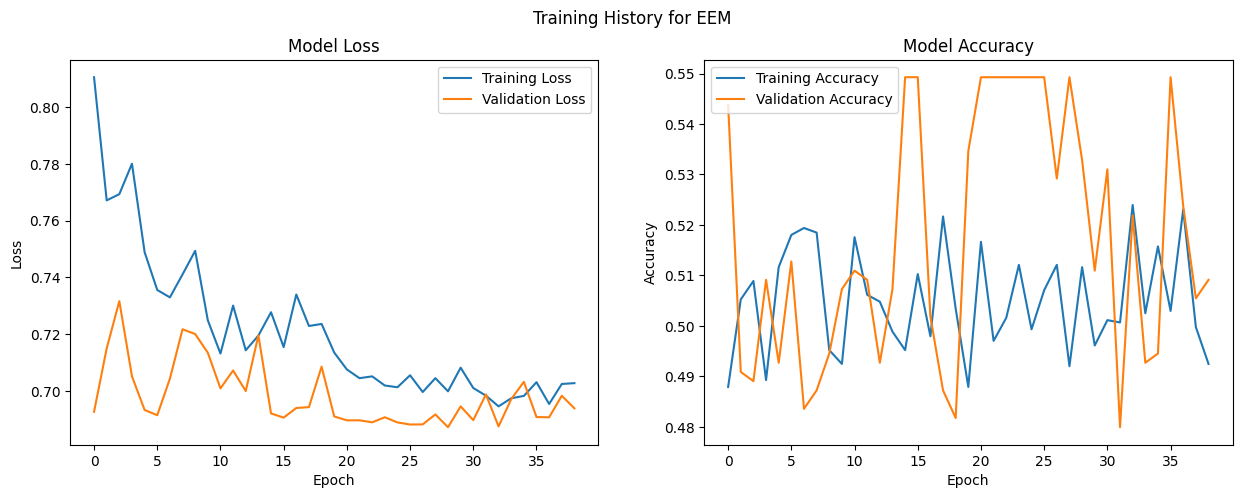


--- Plotting for: Gold ---


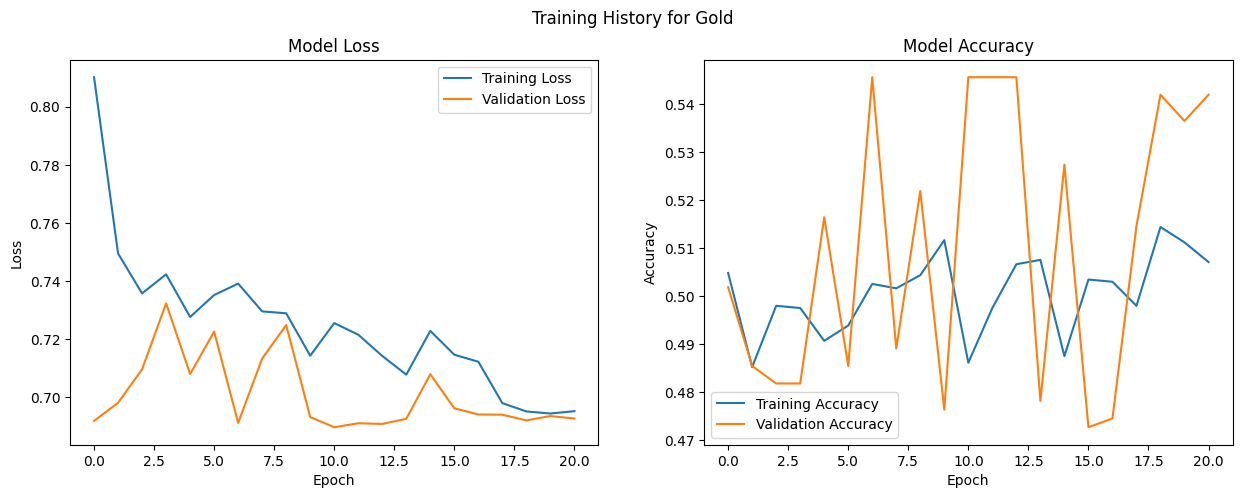


--- Plotting for: FTSE100 ---


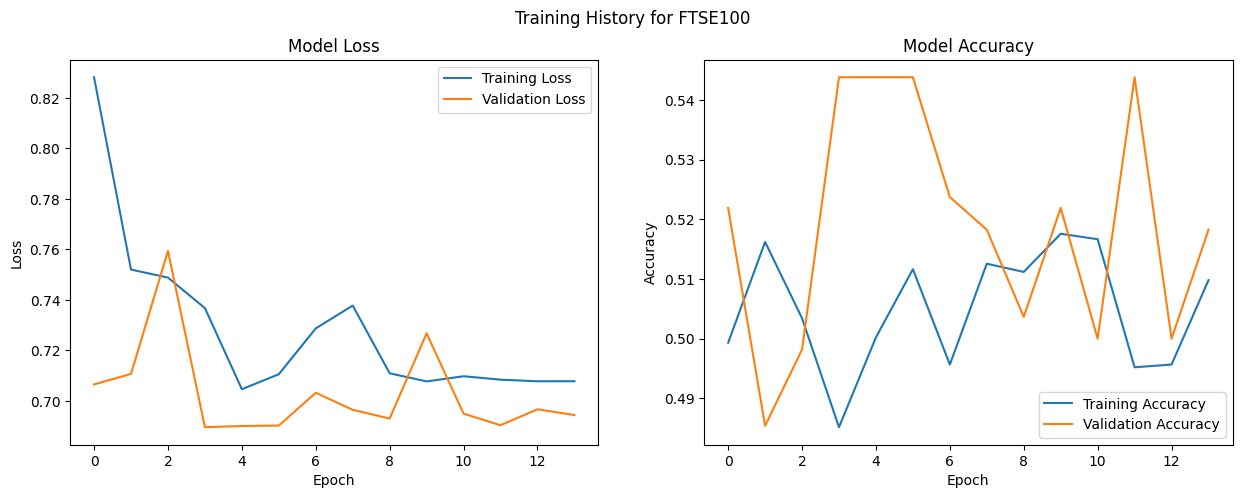


--- Plotting for: S&P500 ---


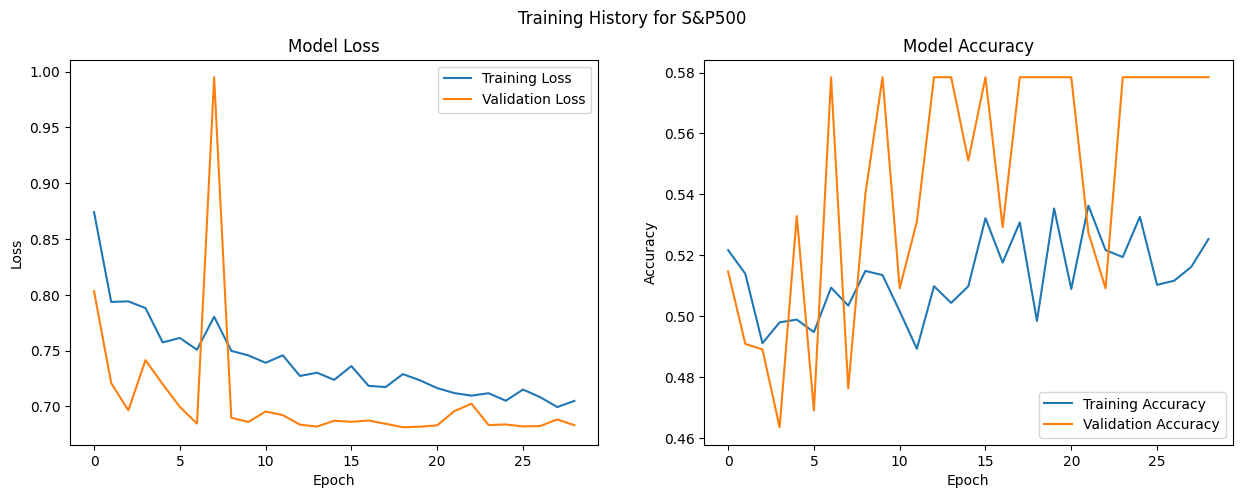


--- Plotting for: Nikkei225 ---


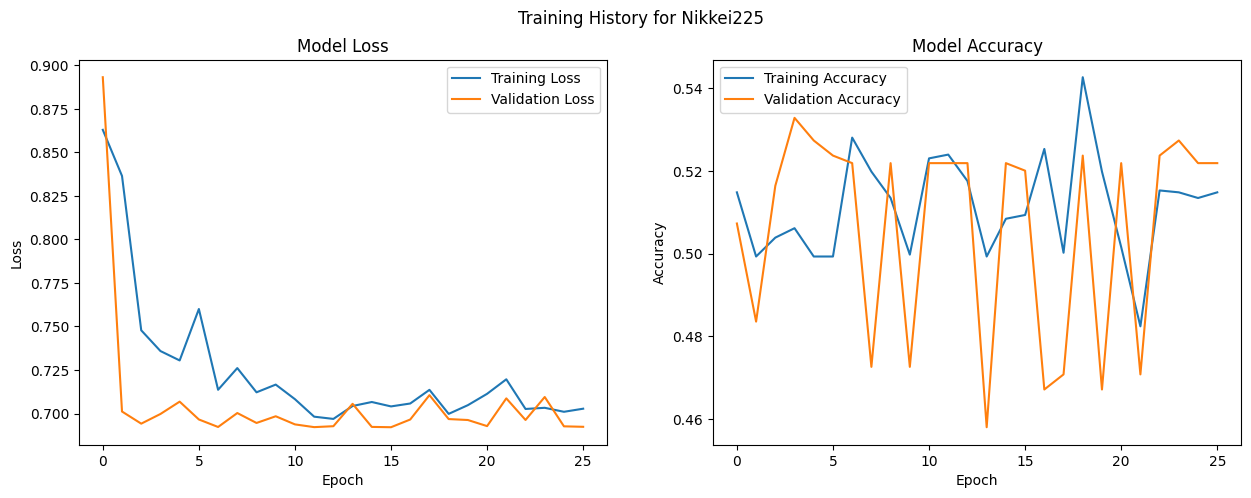


--- Plotting for: UST10Y ---


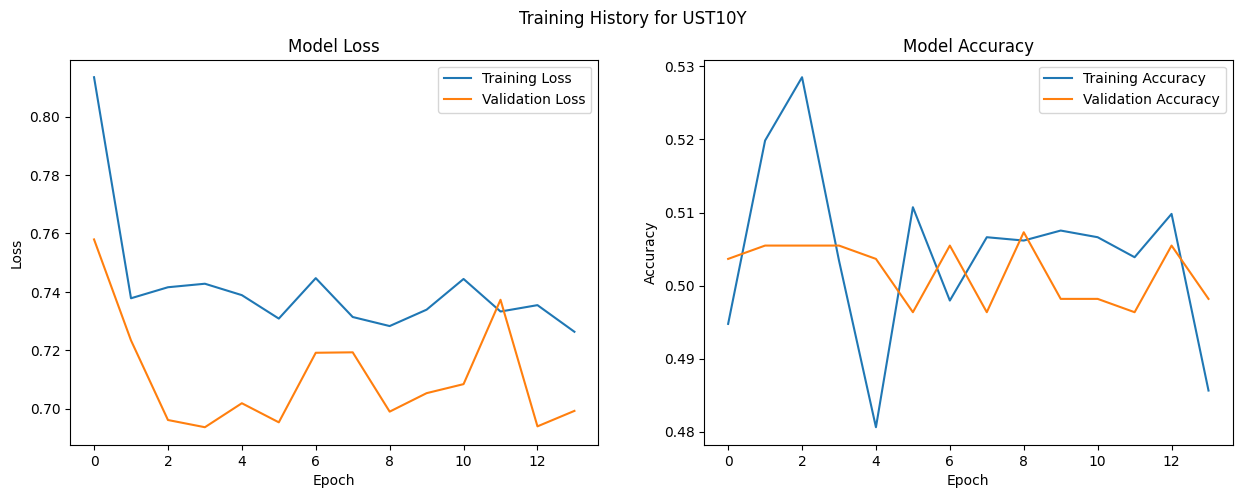

In [54]:
import matplotlib.pyplot as plt
#PLotting the same just incase so that it's easier to read from here

print("\n--- Generating Training History Graphs for All Assets ---")

for asset in assets:
    if asset in history_dict:
        print(f"\n--- Plotting for: {asset} ---")
        history = history_dict[asset]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f'Training History for {asset}')

        
        ax1.plot(history.history['loss'], label='Training Loss')
        ax1.plot(history.history['val_loss'], label='Validation Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        ax2.plot(history.history['accuracy'], label='Training Accuracy')
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        
        plt.show()

